<a href="https://colab.research.google.com/github/Dharmendra04/CNN-Model/blob/main/Neural_network_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Insatlling Pyorch

!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from torch.utils.tensorboard import SummaryWriter

In [ ]:
#check pytorch version
print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


In [ ]:
#for each channel(RGB) mean is 0.5 and sd is 0.5
transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_transform = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])

# Load the datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)

# Split the train_set into train and validation sets
train_set_size = len(train_set)
train_set_indices = list(range(train_set_size))
split = int(train_set_size * 0.8)  # 80% for training, 20% for validation

train_subset = torch.utils.data.Subset(train_set, train_set_indices[:split])
val_subset = torch.utils.data.Subset(train_set, train_set_indices[split:])

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=128, shuffle=False)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13389148.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([128, 3, 32, 32])
torch.Size([128])
labels: tensor([7, 6, 1, 0, 9, 8, 6, 4, 5, 4, 0, 2, 4, 3, 3, 8, 5, 2, 4, 6, 9, 6, 1, 0,
        2, 4, 0, 0, 8, 9, 0, 1, 5, 8, 8, 8, 6, 4, 7, 1, 8, 3, 2, 2, 5, 6, 3, 2,
        5, 5, 3, 5, 6, 8, 7, 3, 0, 6, 4, 0, 9, 5, 8, 1, 2, 6, 2, 8, 1, 4, 9, 2,
        0, 5, 2, 2, 0, 8, 6, 1, 8, 8, 5, 0, 7, 9, 4, 8, 5, 0, 8, 6, 8, 9, 0, 8,
        6, 8, 5, 5, 5, 1, 3, 6, 1, 8, 7, 2, 1, 5, 4, 3, 8, 9, 1, 2, 6, 3, 1, 2,
        0, 8, 4, 4, 3, 8, 9, 9])


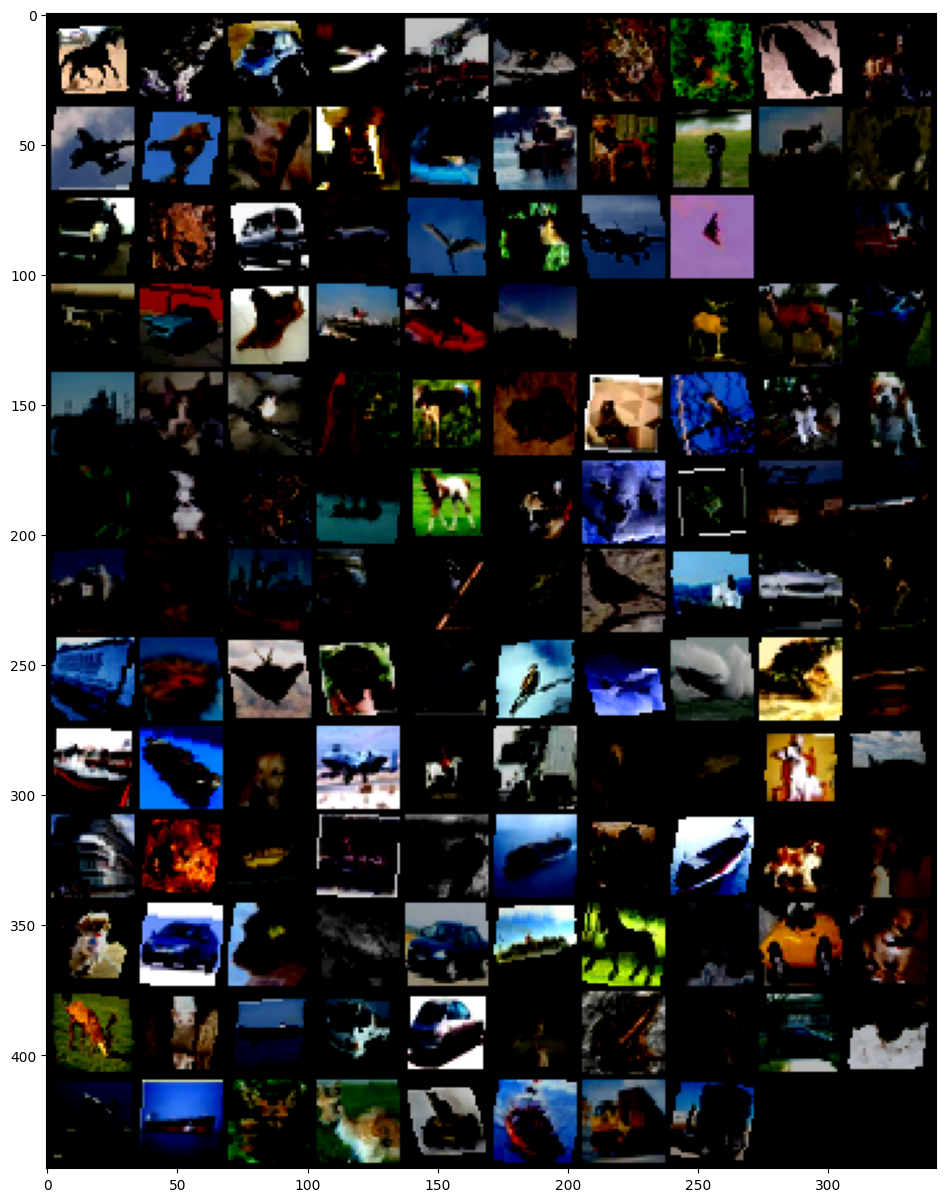

In [ ]:
#visualising the images in a batch
batch = next(iter(train_loader))

images, labels = batch

print(images.shape)
print(labels.shape)
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))

print('labels:', labels)

Model Architecture

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3))
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,1))

    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,5))
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3))
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3))
    
    self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3))
   

    self.fc1 = nn.Linear(in_features=128*1*1, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.out = nn.Linear(in_features=84, out_features=10)

    self.droput = torch.nn.Dropout(p=0.2, inplace=False)

    self.initialise_weights()

  #He_initialisation
  def initialise_weights(self):
    for m in self.modules():
      if isinstance(m,nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight)
      
        if m.bias is not None:
          nn.init.constant_(m.bias,0)
          
      elif isinstance(m,nn.BatchNorm2d):
       nn.init.constant_(m.weight,1)
       nn.init.constant_(m.bias,0)

      elif isinstance(m,nn.Linear):
       nn.init.kaiming_uniform_(m.weight)
       nn.init.constant_(m.bias,0)

  def forward(self, t):
    #Layer 1
    t = t 
    t1 = t.reshape(-1,3*32*32) #will be added as residual connection
    #Layer 2
    t = self.conv1(t) #(64,30,30)
    t = F.relu(t)
    

    #layer 3
    t = self.conv2(t)#(64,28,28)
    t = F.relu(t)
   
    
    #layer 4
    t = self.conv3(t) #(64,28,28)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2) #(3,14,14)

    #layer 5
    t = self.conv4(t) #(128,10,10)
    t = F.relu(t)
    
    #layer 6
    t = self.conv5(t) #(128,8,8)
    t = F.relu(t)

    #layer 7
    t = self.conv6(t) #128,6,6)
    t = F.relu(t)
    

    t = F.max_pool2d(t, kernel_size=2, stride=2)#output shape : (128,3,3)

     #layer 8
    t = self.conv7(t) #128,1,1)
    t = F.relu(t)

    
   

    #Linear Layer 1
    t = t.reshape(-1,128*1*1) #change the filter size compulsoryly
    t =self.droput(t)
    t = self.fc1(t)
    t = F.relu(t)#output shape : (1,120)

    #Linear Layer 2
    t =self.droput(t)
    t = self.fc2(t)
    t = F.relu(t)
    
    
    #Linear Layer 3/ Output Layer
    t = self.out(t)#output shape : (1,10)
    return t

network = Network()

Latest Currently used

In [ ]:
#optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',min_lr =0.0008,patience =3)

In [ ]:
training_loss= []
train_accuracy = []
val_loss = []
validation_accuracy = []

#Training
for epoch in range(60):
  total_incorrect=0
  total_correct = 0
  total_loss = 0
  for batch in train_loader: #Get batch
    images, labels = batch #Unpack the batch into images and labels
 
    preds = network(images) #Pass batch
    loss = F.cross_entropy(preds, labels) #Calculate Loss

    optimizer.zero_grad()
    loss.backward() #Calculate gradients
    optimizer.step() #Update weights

    total_loss += loss.item() #training loss
    total_correct += preds.argmax(dim=1).eq(labels).sum().item()
    total_incorrect += (preds.argmax(dim=1) != labels).sum().item()

  training_accuracy = (total_correct/(total_correct+total_incorrect))*100 #training accuracy


#Validation 
  with torch.no_grad():
    total_incorrect1=0
    total_correct1 = 0
    total_loss1 = 0

    for batch1 in val_loader: #Get batch
      images1, labels1 = batch1 #Unpack the batch into images and labels
  
      preds1 = network(images1) #Pass batch
      loss1 = F.cross_entropy(preds1, labels1) #Calculate Loss

      total_loss1 += loss1.item() #validation loss
      total_correct1 += preds1.argmax(dim=1).eq(labels1).sum().item()
      total_incorrect1 += (preds1.argmax(dim=1) != labels1).sum().item()

  scheduler.step(total_loss1) #scheduler 
  val_accuracy = (total_correct1/(total_correct1+total_incorrect1))*100 #validation accuracy
  
  print('epoch:', epoch, "total_correct_val:", total_correct1, "loss_val:", total_loss1, 'validation_accuracy:',val_accuracy)
  print('epoch:', epoch, "total_correct_train:", total_correct, "loss_train:", total_loss, 'training_accuracy:',training_accuracy)

  training_loss.append(total_loss)
  train_accuracy.append(training_accuracy)

  val_loss.append(total_loss1)
  validation_accuracy.append(val_accuracy)
print('>>> Training Complete >>>')

epoch_count = list(range(1,len(val_loss)+1,1)) 

epoch: 0 total_correct_val: 4020 loss_val: 128.64489138126373 validation_accuracy: 40.2
epoch: 0 total_correct_train: 11599 loss_train: 588.4127109050751 training_accuracy: 28.9975
epoch: 1 total_correct_val: 4857 loss_val: 112.88442313671112 validation_accuracy: 48.57
epoch: 1 total_correct_train: 17716 loss_train: 473.55180418491364 training_accuracy: 44.29
epoch: 2 total_correct_val: 5236 loss_val: 106.46110939979553 validation_accuracy: 52.35999999999999
epoch: 2 total_correct_train: 20810 loss_train: 419.0763039588928 training_accuracy: 52.025
epoch: 3 total_correct_val: 5876 loss_val: 93.01497024297714 validation_accuracy: 58.76
epoch: 3 total_correct_train: 22582 loss_train: 385.13128250837326 training_accuracy: 56.455
epoch: 4 total_correct_val: 6012 loss_val: 90.48029553890228 validation_accuracy: 60.12
epoch: 4 total_correct_train: 24085 loss_train: 356.2630435824394 training_accuracy: 60.212500000000006
epoch: 5 total_correct_val: 6171 loss_val: 87.43907707929611 validation_

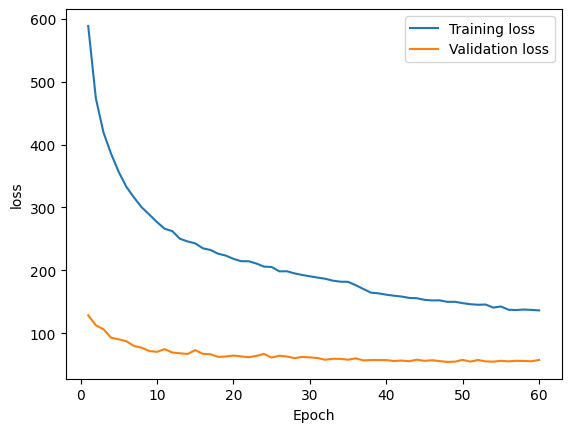

In [ ]:
# Plot the training accuracy and validation accuracy
plt.plot(epoch_count, training_loss, label='Training loss')
plt.plot(epoch_count, val_loss, label='Validation loss')

# Add a legend and axis labels
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')

# Show the plot
plt.show()

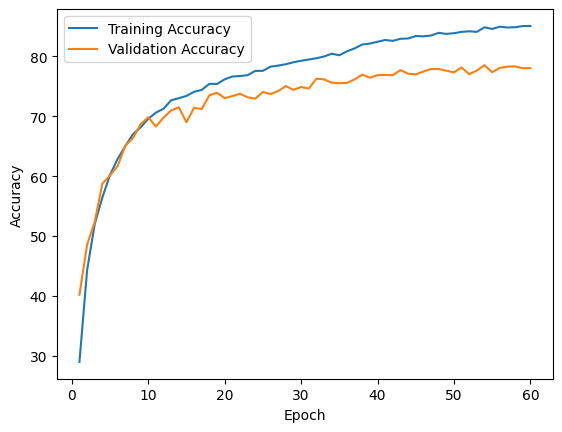

In [ ]:
# Plot the training accuracy and validation accuracy
plt.plot(epoch_count, train_accuracy, label='Training Accuracy')
plt.plot(epoch_count, validation_accuracy, label='Validation Accuracy')

# Add a legend and axis labels
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

In [ ]:
PATH = './cifar_net.pth'
torch.save(network.state_dict(), PATH)

In [ ]:
network = Network()
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds

In [ ]:
test_preds = get_all_preds(network, test_loader)
actual_labels = torch.Tensor(test_set.targets)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_set))

total correct: 8085
accuracy: 0.8085


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[817  11  58  22  11   2   2  13  45  19]
 [ 11 912   3   8   4   4   3   0  10  45]
 [ 31   3 748  60  60  44  23  17   9   5]
 [ 12   3  53 650  46 171  23  23   9  10]
 [  6   0  52  41 823  26  13  34   3   2]
 [  4   2  39 117  29 761   3  40   1   4]
 [  4   1  54  41  46  40 805   4   4   1]
 [ 13   1  23  29  33  56   1 840   2   2]
 [ 56  21  10  14   6   2   1   2 872  16]
 [ 20  62   7  11   2  11   5   9  16 857]]


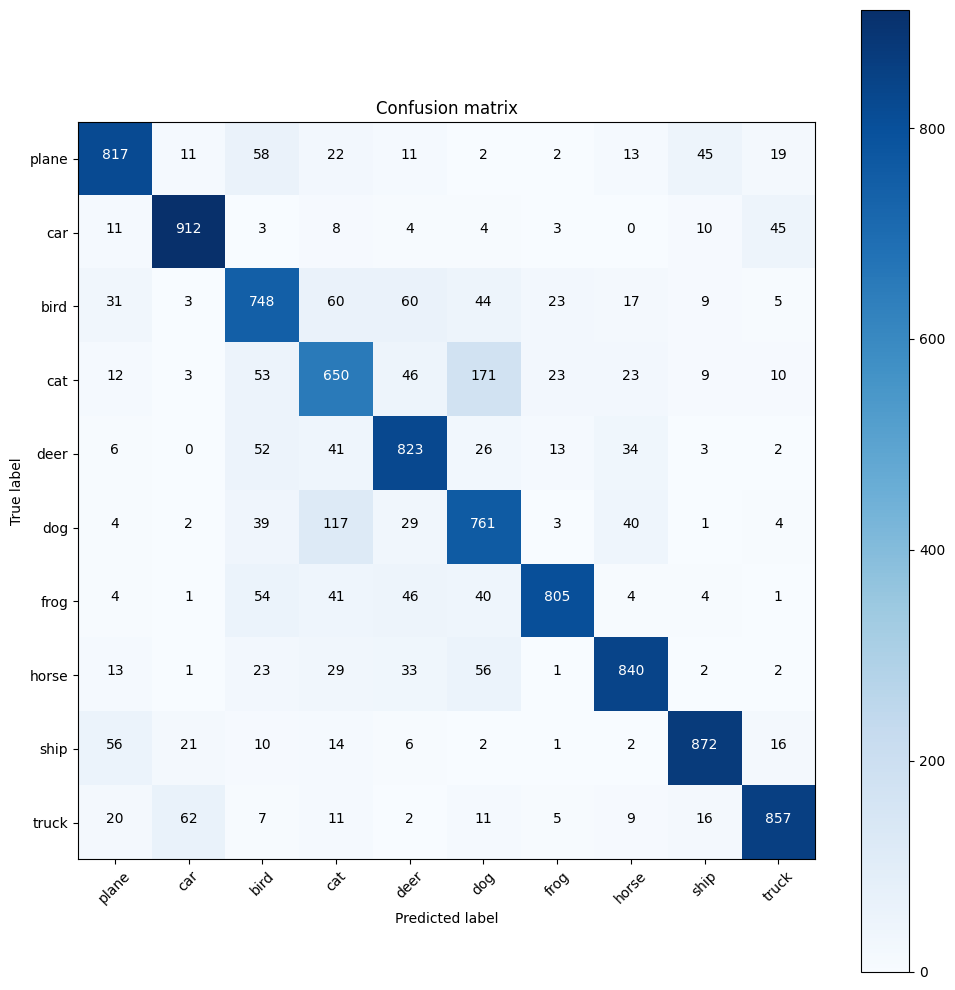

In [ ]:
cm = confusion_matrix(test_set.targets, test_preds.argmax(dim=1))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)